# Imports and data loading
The next three cells are pre-requisites to the later Nilearn cells, run them in order and adjust parameters in the second cell (especially dpath and anat_fname)

In [1]:
import pandas as pd
import os.path as op
import retro
from src.features.annotations import generate_key_events, generate_aps_events, plot_bidsevents
from src.features.features import compute_framewise_aps
import matplotlib.pyplot as plt
from src.params import figures_path
from nilearn import plotting
from nilearn import image
import os
import numpy as np
from nilearn.plotting import plot_design_matrix
import load_confounds
from nilearn.input_data import NiftiMasker
from nilearn.glm.first_level import FirstLevelModel

# This is a modified version of src.data.data.retrieve_variables, adapted to the naming of scan-related behavioural files
def retrieve_variables(files):
    '''
    files : list of files with complete path

    variable_lists : dictionnary (each variable is an entry) containing list of arrays of
    length corresponding to the number of frames in each run,
    with runs ordered by timestamp.
    '''

    variables_lists = {}

    for file in files:
        level = file[-11:-8]
        timestamp = file[-73:-65]
        print(file)
        if level == '5-0':
            env = retro.make('ShinobiIIIReturnOfTheNinjaMaster-Genesis', state='Level5')
        else:
            env = retro.make('ShinobiIIIReturnOfTheNinjaMaster-Genesis', state='Level'+level)
        actions = env.buttons

        run_variables = {}
        key_log = retro.Movie(file)
        env.reset()
        run_completed = False
        while key_log.step():
            a = [key_log.get_key(i, 0) for i in range(env.num_buttons)]
            _,_,done,i = env.step(a)

            if variables_lists == {}: # init final dict
                variables_lists['filename'] = []
                variables_lists['timestamp'] = []
                variables_lists['level'] = []
                for action in actions:
                    variables_lists[action] = []
                for variable in i.keys():
                    variables_lists[variable] = []

            if run_variables == {}: # init temp dict
                for variable in i.keys():
                    run_variables[variable] = []
                for action in actions:
                    run_variables[action] = []

            for variable in i.keys(): # fill up temp dict
                run_variables[variable].append(i[variable])
            for idx_a, action in enumerate(actions):
                run_variables[action].append(a[idx_a])

            if done == True:
                run_completed = True
        variables_lists['filename'].append(file)
        variables_lists['timestamp'].append(timestamp)
        variables_lists['level'].append(level)

        for variable in run_variables.keys():
            variables_lists[variable].append(run_variables[variable])
        env.close()
    return variables_lists


# This will go in src.features.annotations
def create_runevents(runvars, startevents, actions, FS=60, min_dur=1, get_aps=True, get_actions=True):
    onset_reps = startevents['onset'].values.tolist()
    dur_reps = startevents['duration'].values.tolist()
    lvl_reps = [x[-11] for x in startevents['stim_file'].values.tolist()]
    
    if get_aps:
        framewise_aps = compute_framewise_aps(runvars, actions=actions, FS=FS)

    # init df list
    all_df = []

    for idx, onset_rep in enumerate(onset_reps):
        print('Extracting events for {}'.format(runvars['filename'][idx]))
        if get_actions:
            # get the different possible actions
            # generate events for each of them
            for act in actions:
                var = runvars[act][idx]
                temp_df = generate_key_events(var, act, FS=FS)
                temp_df['onset'] = temp_df['onset'] + onset_rep
                temp_df['trial_type'] = lvl_reps[idx] + '_' + temp_df['trial_type']
                all_df.append(temp_df)
        if get_aps:
            temp_df = generate_aps_events(framewise_aps[idx], FS=FS)
            temp_df['onset'] = temp_df['onset'] + onset_rep
            temp_df['trial_type'] = lvl_reps[idx] + '_' + temp_df['trial_type']
            all_df.append(temp_df)

    events_df = pd.concat(all_df).sort_values(by='onset').reset_index(drop=True)
    return events_df


In [2]:
# Set constants for single subject, single run
sub = 'sub-01'
ses = 'ses-008'
run = '1'
actions = ['B', 'A', 'MODE', 'START', 'UP', 'DOWN', 'LEFT', 'RIGHT', 'C', 'Y', 'X', 'Z']
dpath = '/home/hyruuk/pCloudDrive/Temp_DATA/shinobi/'
events_fname = dpath + 'shinobi/{}/{}/func/{}_{}_task-shinobi_run-0{}_events.tsv'.format(sub, ses, sub, ses, run)
data_fname = dpath + 'shinobi/derivatives/fmriprep-20.2lts/fmriprep/{}/{}/func/{}_{}_task-shinobi_run-{}_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz'.format(sub, ses, sub, ses, run)
confounds_fname = dpath + 'shinobi/derivatives/fmriprep-20.2lts/fmriprep/{}/{}/func/{}_{}_task-shinobi_run-{}_desc-confounds_timeseries.tsv'.format(sub, ses, sub, ses, run)
anat_fname = dpath + 'anat/derivatives/fmriprep-20.2lts/fmriprep/{}/anat/{}_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz'.format(sub, sub)

In [22]:
# Obtain list of bk2 files from events
startevents = pd.read_table(events_fname)
files = startevents['stim_file'].values.tolist()
files = [dpath + file for file in files]

# Retrieve variables from these files
runvars = retrieve_variables(files)
events_df = create_runevents(runvars, startevents, actions=actions)
events_df['trial_type'].unique()

# Create LvR_df
lh_df = pd.concat([events_df[events_df['trial_type'] == '1_LEFT'], 
                   events_df[events_df['trial_type'] == '1_RIGHT'],
                   events_df[events_df['trial_type'] == '1_DOWN'],
                   events_df[events_df['trial_type'] == '1_UP'],
                   events_df[events_df['trial_type'] == '4_LEFT'], 
                   events_df[events_df['trial_type'] == '4_RIGHT'],
                   events_df[events_df['trial_type'] == '4_DOWN'],
                   events_df[events_df['trial_type'] == '4_UP'],
                    events_df[events_df['trial_type'] == '5_LEFT'], 
                   events_df[events_df['trial_type'] == '5_RIGHT'],
                   events_df[events_df['trial_type'] == '5_DOWN'],
                   events_df[events_df['trial_type'] == '5_UP']
                  ]).sort_values(by='onset').reset_index(drop=True)
lh_df['trial_type'] = 'LeftH'

rh_df = pd.concat([events_df[events_df['trial_type'] == '1_B'], 
                   events_df[events_df['trial_type'] == '1_C'],
                   events_df[events_df['trial_type'] == '4_B'], 
                   events_df[events_df['trial_type'] == '4_C'],
                    events_df[events_df['trial_type'] == '5_B'], 
                   events_df[events_df['trial_type'] == '5_C']
                  ]).sort_values(by='onset').reset_index(drop=True)
rh_df['trial_type'] = 'RightH'

LvR_df = pd.concat([lh_df, rh_df]).sort_values(by='onset').reset_index(drop=True)


# Load and concat 3d images
fmri_img = image.concat_imgs(data_fname)

/home/hyruuk/pCloudDrive/Temp_DATA/shinobi/sourcedata/sub-01/ses-shinobi_008/sub-01_ses-shinobi_008_20201113-104817_ShinobiIIIReturnOfTheNinjaMaster-Genesis_Level1-0_000.bk2
/home/hyruuk/pCloudDrive/Temp_DATA/shinobi/sourcedata/sub-01/ses-shinobi_008/sub-01_ses-shinobi_008_20201113-104817_ShinobiIIIReturnOfTheNinjaMaster-Genesis_Level4-1_000.bk2
/home/hyruuk/pCloudDrive/Temp_DATA/shinobi/sourcedata/sub-01/ses-shinobi_008/sub-01_ses-shinobi_008_20201113-104817_ShinobiIIIReturnOfTheNinjaMaster-Genesis_Level5-0_000.bk2
/home/hyruuk/pCloudDrive/Temp_DATA/shinobi/sourcedata/sub-01/ses-shinobi_008/sub-01_ses-shinobi_008_20201113-104817_ShinobiIIIReturnOfTheNinjaMaster-Genesis_Level1-0_001.bk2
Extracting events for /home/hyruuk/pCloudDrive/Temp_DATA/shinobi/sourcedata/sub-01/ses-shinobi_008/sub-01_ses-shinobi_008_20201113-104817_ShinobiIIIReturnOfTheNinjaMaster-Genesis_Level1-0_000.bk2
Extracting events for /home/hyruuk/pCloudDrive/Temp_DATA/shinobi/sourcedata/sub-01/ses-shinobi_008/sub-01_se

# Data analysis with Nilearn

The correct files are now loaded and the events_df is created based on behavioural logs. We are ready to run some GLMs.

Running a GLM on a single run without loading any confounds or anatomical mask is fairly easy. Running the same analysis with multiple runs is a bit computationally heavier, but the code is as straight-forward as for single runs (just append the fmri_imgs of the different runs in a list, and pass this list to glm.fit_transform instead of the single-run fmri_img, and do the same to pass events as a list of dataframes). 

However, there are three additional steps that I still need to implement in the pipeline :
1. I need to use the anatomical image to create a mask that will have a higher spatial resolution than the mask automatically generated from functional images. Then, all fmri_imgs must be transformed with this mask so they keep the same shape.
2. I need to take confounds into account, especially since movements are likely to be a key source of artifacts in a video game paradigm. 
3. I need to manually high-pass filter and normalize the hand regressors.

Let's start with a bit of code that works, and then we shall see what doesn't.

In [23]:
# Code that works
fmri_glm = FirstLevelModel(t_r=1.49,
                           noise_model='ar1',
                           standardize=False,
                           hrf_model='spm',
                           drift_model='cosine',
                           high_pass=.01,
                           n_jobs=-1,
                           smoothing_fwhm=5)

fmri_glm = fmri_glm.fit(fmri_img, LvR_df) # for multiple runs, fmri_img and LvR_df are lists of NiftiImgs and DataFrames, respectively


In [24]:
# Since that worked, let's treat ourselves a quick report
fmri_glm.generate_report(contrasts=['LeftH-RightH'])

So now, let's see how I can (spoiler : can't) reach that same step (i.e. fitted GLM able to generate a fine report) but this time, with the addition of step 1, 2 or 3.

## Step 1 : Project the functional images on the anatomical image

In [63]:
# 1st try : Build masker from anat_img and pass it to FLM

masker = NiftiMasker(mask_img=anat_fname) # could it be that easy ??

fmri_glm = FirstLevelModel(t_r=1.49,
                           noise_model='ar1',
                           standardize=False,
                           hrf_model='spm',
                           drift_model='cosine',
                           high_pass=.01,
                           n_jobs=-1,
                           smoothing_fwhm=5,
                          mask_img=masker) # don't forget to pass the masker to FLM

fmri_glm = fmri_glm.fit(fmri_img, LvR_df)

AttributeError: 'NiftiMasker' object has no attribute 'mask_img_'

Ok I remember now : if it's too good to be true, it probably is.

So, what happened here ? It seems that loading the masker with mask_img=anat_fname does create a mask fitted to the anatomical image, but doesn't transform any data with it. 
From what I understand, I would expect the transform() step to be performed in the FLM class from the specified masker, that way it can iterate the different runs with the same masker. But that doesn't seem to be the case, so let's try to transform the data beforehand.

In [4]:
# 2nd try : Build masker from anat_img and pass it to FLM, but fit the data beforehand

masker = NiftiMasker(mask_img=anat_fname) # obviously not that easy
masker = masker.transform(fmri_img)


fmri_glm = FirstLevelModel(t_r=1.49,
                           noise_model='ar1',
                           standardize=False,
                           hrf_model='spm',
                           drift_model='cosine',
                           high_pass=.01,
                           n_jobs=-1,
                           smoothing_fwhm=5,
                          mask_img=masker) # don't forget to pass the masker to FLM

fmri_glm = fmri_glm.fit(fmri_img, LvR_df)

ValueError: It seems that NiftiMasker has not been fitted. You must call fit() before calling transform().

Ok so apparently mask_img=anat_fname doesn't even fit the anatomical image on the masker... What does it do then ?
That code is probably wrong anyway since I'm transforming the fmri data with the masker, then pass the transformed masker to FLM, then fit the non-transformed data to it... Sound not good at all.

So let's try "intuitively" cleaning that up by only passing the transformed fmri data to FLM.fit().

In [5]:
# 3rd try : Build empty masker, fit with anat_img, transform fmri_img, and pass the transformed fmri_img to FLM.fit()

masker = NiftiMasker() # create an empty masker
masker = masker.fit(anat_fname) # fit anatomical image
fmri_masked = masker.transform(fmri_img) # create transformed fmri data

fmri_glm = FirstLevelModel(t_r=1.49,
                           noise_model='ar1',
                           standardize=False,
                           hrf_model='spm',
                           drift_model='cosine',
                           high_pass=.01,
                           n_jobs=-1,
                           smoothing_fwhm=5) # no need to pass the mask anymore since we only use the transformed data

fmri_glm = fmri_glm.fit(fmri_masked, LvR_df) # pass fmri_masked instead of fmri_img

TypeError: Data given cannot be loaded because it is not compatible with nibabel format:
5209.025

Oh ! An error message that we've never seen before !

![New error message](https://i.imgflip.com/4qnydl.jpg)

But, in all seriousness, what does this error really mean ? It sounds like some data shapes were not matching, but it could be something else... 
Maybe it's because I decided not to pass the masker to FLM ? Let's try this :

In [6]:
# 4th try : Same but also pass the masker to FLM

masker = NiftiMasker() # create an empty masker
masker = masker.fit(anat_fname) # fit anatomical image
fmri_masked = masker.transform(fmri_img) # create transformed fmri data

fmri_glm = FirstLevelModel(t_r=1.49,
                           noise_model='ar1',
                           standardize=False,
                           hrf_model='spm',
                           drift_model='cosine',
                           high_pass=.01,
                           n_jobs=-1,
                           smoothing_fwhm=5,
                          mask_img=masker) # mask_img argument is back

fmri_glm = fmri_glm.fit(fmri_masked, LvR_df) # pass fmri_masked instead of fmri_img

TypeError: Data given cannot be loaded because it is not compatible with nibabel format:
5209.025

Same error... I think I'm running out of ideas about that one.

Unless... It is actually so easy that I simply have to give the anat file to mask_img in the FLM call ?

In [7]:
# 4th try : Same but also pass the masker to FLM

fmri_glm = FirstLevelModel(t_r=1.49,
                           noise_model='ar1',
                           standardize=False,
                           hrf_model='spm',
                           drift_model='cosine',
                           high_pass=.01,
                           n_jobs=-1,
                           smoothing_fwhm=5,
                          mask_img=anat_fname) # directly pass the filename of the anatomical image 

fmri_glm = fmri_glm.fit(fmri_img, LvR_df)

And I guess that... works...? 

Let's generate a report to confirm everything went smoothly.

In [8]:
fmri_glm.generate_report(contrasts=['LeftH-RightH'])

Much cleaner indeed, looks like that *did* work.
Ok, let's forget about the first three attempts, shall we ? ^^'  
Lesson learned, clearing my head and my code (and talking to you, awesome rubber duck) really helped me overcome that question. 

## Step 2 : Add confounds from .tsv file

Remember : drifts are already computed in the confounds file, so we need to set drift_model=None in FirstLevelModel so they are not computed anew.

Let's start by trying to directly pass the confounds_fname to the flm.fit() call

In [18]:
fmri_glm = FirstLevelModel(t_r=1.49,
                           noise_model='ar1',
                           standardize=False,
                           hrf_model='spm',
                           drift_model='cosine', # reactivate automatic drift compensation
                           high_pass=.01,
                           n_jobs=-1,
                           smoothing_fwhm=5) # let's make this simple and start without anatomical mask 

fmri_glm = fmri_glm.fit(fmri_img, LvR_df, confounds=confounds_fname)

ValueError: array must not contain infs or NaNs

Weird, afaiu there is a default option in load_confounds() that is supposed to take care of these nasty NaNs.  
Let's try again by loading confounds beforehand, who knows.

In [61]:
fmri_glm = FirstLevelModel(t_r=1.49,
                           noise_model='ar1',
                           standardize=False,
                           hrf_model='spm',
                           drift_model='cosine', # reactivate automatic drift compensation
                           high_pass=.01,
                           n_jobs=-1,
                           smoothing_fwhm=5) # let's make this simple and start without anatomical mask 

confounds = load_confounds.Params36().load(confounds_fname)
fmri_glm = fmri_glm.fit(fmri_img, LvR_df, confounds=confounds)

/home/hyruuk/anaconda3/envs/hyruuk_shinobi_behav/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:174: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


IndexError: list index out of range

Another error. Not really what I expected either : I thought glm.fit() would call for load_confounds and give the same result as above but it seems not to be the case.  
Alright so, according to the [documentation of load_confounds()](https://github.com/SIMEXP/load_confounds), confounds can be "applied" to the data by transforming them using a masker object. Let's try that.

In [33]:
masker = NiftiMasker()
masker.fit(fmri_img)
confounds = load_confounds.Params36().load(confounds_fname)
fmri_img_conf = masker.transform(fmri_img, confounds=confounds)

/home/hyruuk/anaconda3/envs/hyruuk_shinobi_behav/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:174: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


Alright alright we're getting somewhere ! There is only one thing left to do : running the FLM

Note : that warning message might be informative in some way, but I'm not sure yet that it's really problematic for now.

In [53]:
fmri_glm = FirstLevelModel(t_r=1.49,
                           noise_model='ar1',
                           standardize=False,
                           hrf_model='spm',
                           drift_model=None, # we already took care of the confounds when transforming the fmri_img
                           high_pass=.01,
                           n_jobs=-1,
                           smoothing_fwhm=5)

fmri_glm = fmri_glm.fit(fmri_img_conf, LvR_df) # here we pass the fmri_img that have been transformed


TypeError: Data given cannot be loaded because it is not compatible with nibabel format:
94.041466

Uh-oh, looks like masker.transform() changed the shape of the image ?
Actually, according to the [Nilearn documentation](https://nilearn.github.io/modules/generated/nilearn.input_data.NiftiMasker.html), 
it is expected that the output of masker.transform() should be a 2D matrix. But, previously I was passing a 4D image to FLM and it worked, so let's see if we can go back to 4D.

In [54]:
print(fmri_img.shape) # that's 4D (3D + time)
print(fmri_img_conf.shape) # and that's 2D

(97, 115, 97, 409)
(409, 774696)


What's weird still is that 97 * 97 * 115 =/= 774696

But there is a [Nilearn function](https://nilearn.github.io/modules/generated/nilearn.regions.signals_to_img_maps.html) that might be able to help us. Let's try it.

In [58]:
from nilearn.regions import signals_to_img_maps
fmri_img_new = signals_to_img_maps(fmri_img_conf, fmri_img)

ValueError: shapes (409,774696) and (409,1082035) not aligned: 774696 (dim 1) != 409 (dim 0)

No luck, it seems that the difference between the shapes of fmri_img and fmri_img_conf is problematic here too...
Still have no clue on how to get back to a 4D Nifti image from the region_signals obtained after masker.transform().

I'm not even sure I really need a 4D matrix to input into flm.fit(), but [according to the doc](https://nilearn.github.io/modules/generated/nilearn.glm.first_level.FirstLevelModel.html), it needs to be a Niimg-like object.

I'm out of ideas for now... Let's see what we're able to do about Step 3.

## Step 3 : Hand regressors filtering and normalization

Because we have much more Left Hand than Right Hand trials, that means that the Left/Right hand regressors will have widely different aplitudes. To take care of that, Pierre recommends to high-pass filter and zero-mean both hand regressors, which will make the betas comparable.  
To do that, I need to find the time series corresponding to the hand regressors, process them and input them back in the model.  
  
The first obstacle I see in doing that is that up 'til now, I was directly passing the events_df to the model and letting the object take care of creating the regressors. Can't do that anymore, so I'll need to (1) create/extract hand regressors and (2) find a way to input timeseries regressors instead of events dataframes in the model.

So, instead of passing the events_df, I want to manually [create the design matrices](https://nilearn.github.io/modules/generated/nilearn.glm.first_level.make_first_level_design_matrix.html#nilearn.glm.first_level.make_first_level_design_matrix) :

I need two arguments : events_df and frame_times

In [120]:
t_r = 1.49
n_slices = fmri_img.shape[-1]
frame_times = np.arange(n_slices) * t_r

design_matrix = nilearn.glm.first_level.make_first_level_design_matrix(frame_times, 
                                                                       events=LvR_df,
                                                                      drift_model='cosine') # note, there will probably be something to do about that when the confounds will be added


<ipython-input-121-36e640cf5b37>:4: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


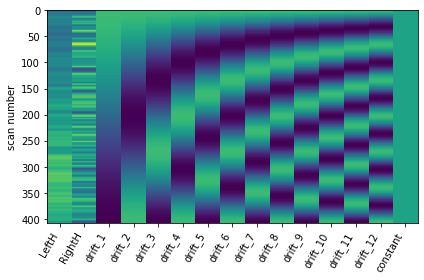

In [121]:
from nistats.reporting import plot_design_matrix
plot_design_matrix(design_matrix)
import matplotlib.pyplot as plt
plt.show()

Here are our regressors ! 
Let's process them and see how that affects the two timeseries.

<ipython-input-124-b5dfdbc410d1>:8: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


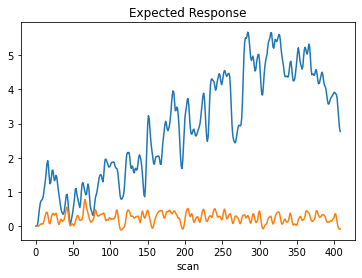

In [124]:
LeftH_ts = np.asarray(design_matrix['LeftH'])
RightH_ts = np.asarray(design_matrix['RightH'])

plt.plot(LeftH_ts)
plt.plot(RightH_ts)
plt.xlabel('scan')
plt.title('Expected Response')
plt.show()

<ipython-input-118-4471f48d3264>:10: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


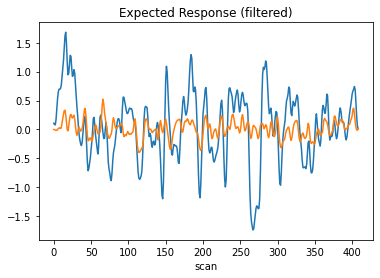

In [118]:
from scipy import signal

b, a = signal.butter(3, 0.01, btype='high')


plt.plot(signal.filtfilt(b, a, LeftH_ts))
plt.plot(signal.filtfilt(b, a, RightH_ts))
plt.xlabel('scan')
plt.title('Expected Response (filtered)')
plt.show()

LeftH_ts_hpf = signal.filtfilt(b, a, LeftH_ts)
RightH_ts_hpf = signal.filtfilt(b, a, RightH_ts)

<ipython-input-119-821c6919ee6f>:8: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


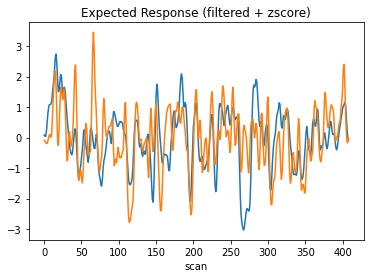

In [119]:
from scipy.stats import zscore


plt.plot(zscore(LeftH_ts_hpf))
plt.plot(zscore(RightH_ts_hpf))
plt.xlabel('scan')
plt.title('Expected Response (filtered + zscore)')
plt.show()

LeftH_ts_hpf_z = zscore(LeftH_ts_hpf)
RightH_ts_hpf_z = zscore(RightH_ts_hpf)

Perfect. Now we just have to input that back in the design matrix and run the model !

In [102]:
design_matrix['LeftH'] = LeftH_ts_hpf_z
design_matrix['RightH'] = RightH_ts_hpf_z

fmri_glm = FirstLevelModel(t_r=1.49,
                           noise_model='ar1',
                           standardize=False,
                           hrf_model='spm',
                           drift_model='cosine',
                           high_pass=.01,
                           n_jobs=-1,
                           smoothing_fwhm=5,
                          mask_img=anat_fname) # directly pass the filename of the anatomical image 

fmri_glm = fmri_glm.fit(fmri_img, design_matrices=design_matrix)
fmri_glm.generate_report(contrasts=['LeftH-RightH'])

# End of the rubber duck
Beware, the cells below are nothing more than a messy dump of potentially useful bits of code. No need to look further, proceed at your own risk.

In [ ]:
masker = NiftiMasker(mask_img=anat_fname)
confounds = load_confounds.Params36().load(confounds_fname)
masked_img = masker.fit_transform(fmri_img, confounds=confounds)

In [ ]:
confounds = load_confounds.Params36().load(confounds_fname)
masker = NiftiMasker()
masker = masker.fit(fmri_img)
masked_img = masker.transform(fmri_img, confounds=confounds)
fmri_img.shape

In [104]:
report = fmri_glm.generate_report(contrasts=['LeftH-RightH'])
report.save_as_html('/home/hyruuk/GitHub/neuromod/hyruuk_shinobi_behav/reports/sub-01_ses-01_flm.html')

In [ ]:
masker.shape

In [ ]:
# Build GLM
from nilearn.glm.first_level import FirstLevelModel
fmri_glm = FirstLevelModel(t_r=1.49,
                           noise_model='ar1',
                           standardize=False,
                           hrf_model='spm',
                           drift_model='cosine',
                           high_pass=.01)

In [ ]:
# Fit
fmri_glm = fmri_glm.fit(fmri_img, LvR_df)

In [ ]:
# Create design_matrix
design_matrix = fmri_glm.design_matrices_[0]

# Plot
from nilearn.plotting import plot_design_matrix
plot_design_matrix(design_matrix)
plt.show()

In [ ]:
# Plot convoluted regressors
plt.plot(design_matrix['LeftH'], label='LeftH')
plt.plot(design_matrix['RightH'], label='RightH')

plt.xlabel('scan')
plt.title('Expected BOLD response')
plt.legend()
plt.show()

In [ ]:
# Create condition arrays
from numpy import array
conditions = {
    'LeftH': array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
    'RightH':   array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
}

In [ ]:
# Subtract conditions
left_minus_right = conditions['LeftH'] - conditions['RightH']

In [ ]:
# Plot contrast
from nilearn.plotting import plot_contrast_matrix
plot_contrast_matrix(left_minus_right, design_matrix=design_matrix)

In [ ]:
# Z score maps

z_map = fmri_glm.compute_contrast(['LeftH-RightH'],
                                    output_type='z_score', stat_type='F')
plotting.plot_stat_map(z_map, bg_img=mean_img)

In [ ]:
# Z threshold

plotting.plot_stat_map(z_map, bg_img=mean_img, threshold=3.0,
              display_mode='z', cut_coords=3, black_bg=True,
              title='Left minus Right Hand (Z>3)')
plt.show()

In [ ]:
# Uncorrected

from nistats.thresholding import map_threshold
uncorr_001, threshold = map_threshold(z_map, alpha=.001, height_control='fpr')
print('Uncorrected p<0.001 threshold: %.3f' % threshold)
plotting.plot_stat_map(z_map, bg_img=mean_img, threshold=threshold,
              display_mode='z', cut_coords=3, black_bg=True,
              title='Left minus Right Hand (p<0.001)')
plt.show()

In [ ]:
# FDR only

_, threshold = map_threshold(z_map, alpha=.05, height_control='fdr')

print('Taux de fausse découverte (FDR) = 0.05 threshold: %.3f' % threshold)

plotting.plot_stat_map(z_map, bg_img=mean_img, threshold=threshold,
              display_mode='z', cut_coords=3, black_bg=True,
              title='sub-01, ses-008, run-01, Left minus Right Hand (fdr=0.05)')
plt.show()

In [ ]:
# FDR + clusters

clean_map, threshold = map_threshold(z_map, alpha=.05, height_control='fdr', cluster_threshold=10)

plotting.plot_stat_map(clean_map, bg_img=mean_img, threshold=threshold,
              display_mode='z', cut_coords=3, black_bg=True,
              title='Left minus Right Hand (FDR=0.05), Noyaux > 10 voxels')
plt.show()

In [ ]:
# Save interactive plot
view = plotting.view_img(clean_map, threshold=3, title='Left minus Right Hand (FDR=0.05), Noyaux > 10 voxels')
view.save_as_html(figures_path + '/LmR_statsmap.html')

In [ ]:
# Set constants for MULTIPLE RUNS
sub = 'sub-01'
actions = ['B', 'A', 'MODE', 'START', 'UP', 'DOWN', 'LEFT', 'RIGHT', 'C', 'Y', 'X', 'Z']
dpath = '/media/hyruuk/Seagate Expansion Drive/DATA/data/shinobi/'



seslist= os.listdir(dpath + sub)

allruns_events = []
fmri_img = []
for ses in ['ses-001']:#sorted(seslist):
    runs = [filename[-13] for filename in os.listdir(dpath + '{}/{}/func'.format(sub, ses)) if 'bold.nii.gz' in filename]
    print(runs)
    for run in sorted(runs):
        print('computing run {}'.format(run))
        events_fname = dpath + '{}/{}/func/{}_{}_task-shinobi_run-0{}_events.tsv'.format(sub, ses, sub, ses, run)
        filename = dpath + 'derivatives/fmriprep-20.2lts/fmriprep/{}/{}/func/sub-01_{}_task-shinobi_run-{}_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz'.format(sub, ses, ses, run)
        confounds_fname = dpath + 'derivatives/fmriprep-20.2lts/fmriprep/{}/{}/func/sub-01_{}_task-shinobi_run-{}_desc-confounds_timeseries.tsv'.format(sub, ses, ses, run)
        # Obtain list of bk2 files from events
        startevents = pd.read_table(events_fname)
        files = startevents['stim_file'].values.tolist()
        files = [dpath + file for file in files]

        # Retrieve variables from these files
        runvars = retrieve_variables(files)
        events_df = create_runevents(runvars, startevents, actions=actions)
        events_df['trial_type'].unique()

        # Create LvR_df
        lh_df = pd.concat([events_df[events_df['trial_type'] == '1_LEFT'], 
                           events_df[events_df['trial_type'] == '1_RIGHT'],
                           events_df[events_df['trial_type'] == '1_DOWN'],
                           events_df[events_df['trial_type'] == '1_UP'],
                           events_df[events_df['trial_type'] == '4_LEFT'], 
                           events_df[events_df['trial_type'] == '4_RIGHT'],
                           events_df[events_df['trial_type'] == '4_DOWN'],
                           events_df[events_df['trial_type'] == '4_UP'],
                            events_df[events_df['trial_type'] == '5_LEFT'], 
                           events_df[events_df['trial_type'] == '5_RIGHT'],
                           events_df[events_df['trial_type'] == '5_DOWN'],
                           events_df[events_df['trial_type'] == '5_UP']
                          ]).sort_values(by='onset').reset_index(drop=True)
        lh_df['trial_type'] = 'LeftH'
        rh_df = pd.concat([events_df[events_df['trial_type'] == '1_B'], 
                           events_df[events_df['trial_type'] == '1_C'],
                           events_df[events_df['trial_type'] == '4_B'], 
                           events_df[events_df['trial_type'] == '4_C'],
                            events_df[events_df['trial_type'] == '5_B'], 
                           events_df[events_df['trial_type'] == '5_C']
                          ]).sort_values(by='onset').reset_index(drop=True)
        rh_df['trial_type'] = 'RightH'
        LvR_df = pd.concat([lh_df, rh_df]).sort_values(by='onset').reset_index(drop=True)
        
        allruns_events.append(LvR_df)
        
        confounds = load_confounds.Params36().load(confounds_fname)
        masker = NiftiMasker()
        masker.fit(filename)
        
        masked_img = masker.transform(filename, confounds=confounds)
        fmri_img.append(masked_img)

        
#import pickle
#with open(dpath + '{}_events_files.pkl'.format(sub), 'wb') as f:
#    pickle.dump(allruns_events, f)
        
        
        
        



In [ ]:
from nilearn.glm.first_level import FirstLevelModel
print('Fitting a GLM')
fmri_glm = FirstLevelModel(t_r=1.49,
                           noise_model='ar1',
                           standardize=False,
                           hrf_model='spm',
                           drift_model='cosine',
                           high_pass=.01,
                           n_jobs=-1,
                           smoothing_fwhm=5)
fmri_glm = fmri_glm.fit(fmri_img, allruns_events)


mean_img = image.mean_img(fmri_img)
plotting.plot_img(mean_img, title='Image de fond (T2* - BOLD)')

In [ ]:
z_map = fmri_glm.compute_contrast(['LeftH-RightH'] * len(fmri_img), 
    output_type='z_score', stat_type='F')

plotting.plot_stat_map(z_map, bg_img=mean_img)

In [ ]:
from nistats.thresholding import map_threshold

clean_map, threshold = map_threshold(z_map, alpha=.05, height_control='fdr', cluster_threshold=10)
uncorr_map, threshold = map_threshold(z_map, alpha=.001, height_control='fpr')


plotting.plot_stat_map(clean_map, bg_img=mean_img, threshold=threshold,
              display_mode='z', cut_coords=3, black_bg=True,
              title='Left minus Right Hand (FDR=0.05), Noyaux > 10 voxels')
plt.show()

In [ ]:
view = plotting.view_img(clean_map, threshold=3, title='Left minus Right Hand (FDR=0.05), Noyaux > 10 voxels')
view.save_as_html(figures_path + '/{}_LmR_statsmap_allruns_FDRcluster.html'.format(sub))

view = plotting.view_img(clean_map, threshold=3, title='Left minus Right Hand (p<0.001), uncorr')
view.save_as_html(figures_path + '/{}_LmR_statsmap_allruns_uncorr.html'.format(sub))

In [ ]:
from nilearn.plotting import plot_design_matrix
plot_design_matrix(fmri_glm.design_matrices_[0])

In [ ]:
['LeftH-RightH'] * len(fmri_img)

In [ ]:
from bids import BIDSLayout
import os

In [ ]:
dpath = '/media/hyruuk/Seagate Expansion Drive/DATA/data/shinobi/derivatives/fmriprep-20.2lts/fmriprep'

layout = BIDSLayout(dpath)

In [ ]:
masker = NiftiMasker()

In [ ]:
img = masker.transform(file, confounds=confounds)